# Analysis of locus variation across mtb complex

These methods were used to analyse the RD900 locus. Assumes the sequence region chosen as reference is the 'complete' version relative to the others. Will not detect insertions.

## How to make a reference sequence for a region in the genome

* go to the genbank nucelotide record for the genome e.g. https://www.ncbi.nlm.nih.gov/nuccore/FR878060.1?report=graph
* click on the Graphics view
* find your region. you can search by gene but it may not always work
* download the fasta and genbank files from the download button on the left. use 'visible range'
* you may have to rename the fasta file header to work nicely with snpgenie, make it something short. also rename the LOCUS and ACCESSION names in the genbank file to match this.

### example for the MAF file used here:

```
>MAF_TBD1 GM041182
CTGGTTCGGATCGGCACCGCGCGCGATGGTGATTCAGGTTCGCGGCCGCCGGGTACCCGCTCGCGCGGTC
CTTGCTGGGCACTACGCGGCATGGCTGGTGGTTTCGGTGATCGTTGCCTGGATGGTGCTGTCATGACTCC
CTCGACATCGGATGCCAGGTCGCGCCGACGCTCGGCGGAGCCCTTCCTGTGGCTGCTGTTCAGCGCCGGG


LOCUS       MAF_TBD1                5756 bp    DNA     linear   BCT 03-APR-2015
DEFINITION  Mycobacterium africanum GM041182 TBD1 locus.
ACCESSION   MAF_TBD1 REGION: 1764053..1769808
```

## find SNPs (snpgenie)

* align samples to a suitable reference locus e.g. MAF TBD1
* call variants
* build tree from snps

## find region deletions 

* use same alignments as above to calculate coverage across the locus
* or view in IGV

## Links

* [MAF GM041182 genome](https://www.ncbi.nlm.nih.gov/nuccore/FR878060.1?report=graph)

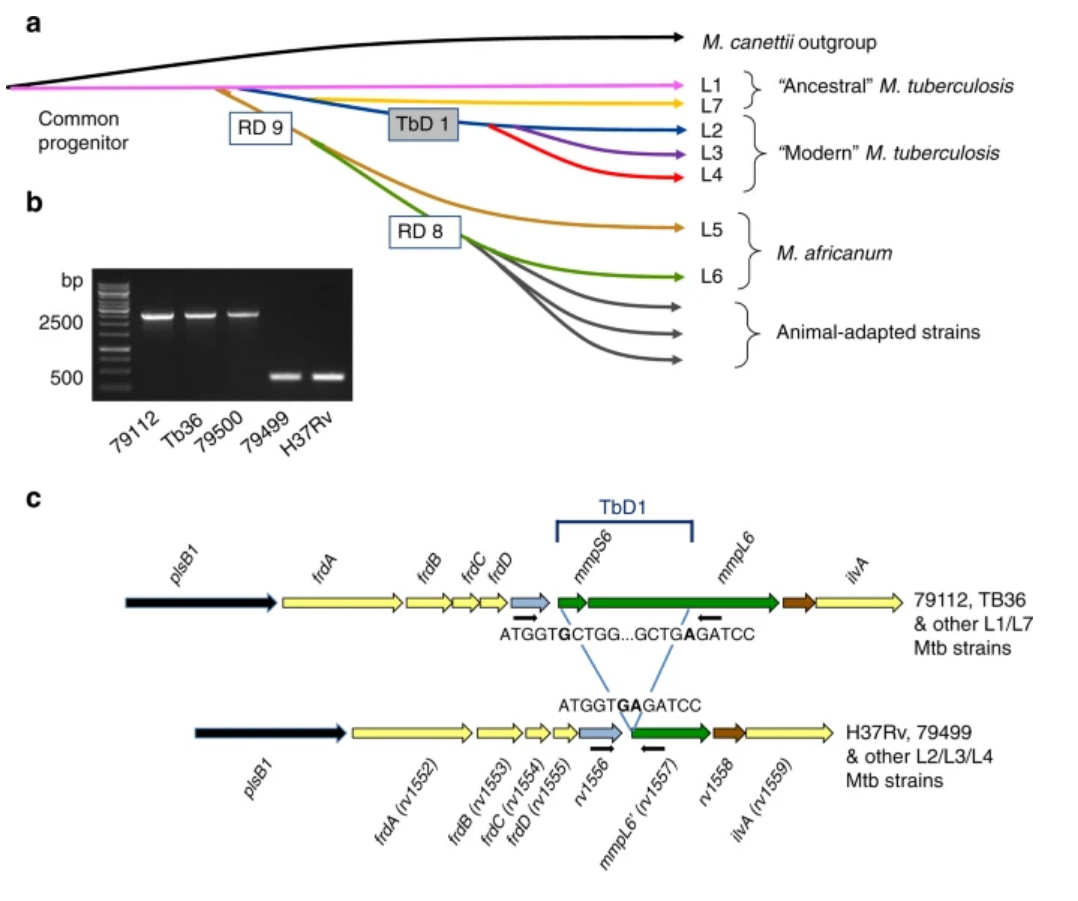

In [1]:
from IPython.display import Image
Image(filename = "tbd1_locus.png", width=600)

In [1]:
import os, io, glob, subprocess
from importlib import reload
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from BCBio import GFF
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from snipgenie import tools, aligners, app, trees, plotting

In [2]:
read_data = pd.read_csv('../genomes_data.csv')
path = '/storage/elena_data'
read_data[-5:]

,ACCESSION,PAIRED,LINEAGE,ORIGIN,BIOPROJECT,BIOSAMPLE,Reads lenght (bp),LINK1,LINK2,REFERENCE
76,ERR4192405,yes,M. tuberculosis L9,Somalia,PRJEB38656,SAMEA6872244,101,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR419/005/...,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR419/005/...,"Swiss Tropical and Public Health Institute, Sw..."
77,ERR4192384,yes,M. tuberculosis L9,Europe,PRJEB38656,SAMEA6872223,101,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR419/004/...,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR419/004/...,"Swiss Tropical and Public Health Institute, Sw..."
78,ERR4162024,yes,M. tuberculosis L9,Somalia,PRJEB38317,SAMEA6847637,35-151,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR416/004/...,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR416/004/...,"Swiss Tropical and Public Health Institute, Sw..."
79,SRR3647355,yes,BCG-26,NaN,PRJNA270004,SAMN03253093,NaN,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR364/005/...,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR364/005/...,pda|big_chen_group
80,ERR234151,yes,M. tuberculosis L6,NaN,PRJEB3223,SAMEA1877109,NaN,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR234/ERR2...,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR234/ERR2...,"Center for Public Health Research, University ..."


## load locus features

In [4]:
rec = list(SeqIO.parse('MAF_GM041182_TBD1.gb',format='gb'))[0]
#remove gene features for plotting
rec.features = [f for f in rec.features if f.type!='gene' ]
#rec.features

## run snipgenie against reference sequence

In [ ]:
args = {'threads':16, 'outdir': 'snipgenie_results', 'labelsep':'-',  
        'input':['/storage/elena_data/'],        
        'reference': 'MAF_GM041182_TBD1.fa', 'gb_file':'MAF_GM041182_TBD1.gb',
        'overwrite':False,
        'filters' : 'QUAL>=30 && FORMAT/DP>=30 && DP4>=4 && MQ>35'
        }
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [19]:
samples = pd.read_csv('snipgenie_results/summary.csv')
samples = samples.merge(read_data,left_on='sample',right_on='ACCESSION')
samples = samples.sort_values('LINEAGE')

# snps

In [ ]:
vdf = tools.vcf_to_dataframe('snipgenie_results/snps.vcf.gz')
vdf[vdf.pos==3420]

In [20]:
c = app.read_csq_file('snipgenie_results/csq.tsv')
#include only snps or also indels?
c=c[c.snp_type!='synonymous']
muts = list(c.aa.dropna().unique())
#muts

In [30]:
X=pd.read_csv('snipgenie_results/csq.matrix')
X = X[X.aa.isin(muts)]
X=X.set_index(['gene','aa','start']).sort_index().drop(columns=['snp_type'])
labelmap = dict(zip(samples.ACCESSION,samples.LINEAGE))
X=X.rename(columns=labelmap)
X[30:50]

M. canetti STB-A  M. tuberculosis L2  BCG-Russia  M. tuberculosis L5  M. microti  M. canetti STB-K-S  M. canetti STB-K-R  M. tuberculosis L7  M. tuberculosis L4  \
gene  aa        start                                                                                                                                                                     
mmpL6 346I>346T 2804                  0                   0           0                   0           0                   1                   1                   0                   0   
      353C>353R 2824                  0                   0           0                   0           0                   1                   1                   0                   0   
      405Y>405H 2980                  1                   0           0                   0           0                   1                   1                   0                   0   
      418M>418V 3019                  0                   0           0                   0           0                   1                   1                   0                   0   
      442M>442I 3093                  0                   0           0                   0           0                   0                   0                   0                   0   
      454I>454V 3127                  0                   0           0                   0           0                   1                   1                   0                   0   
      499K>499T 3263                  0                   0           0                   0           0                   1                   1                   0                   0   
      551N>551K 3420                  0                   0           1                   0           1                   0                   0                   0                   0   
      56D>56A   1934                  1                   0           0                   0           0                   1                   1                   0                   0   
      594D>594H 3547                  0                   0           0                   0           0                   0                   0                   1                   0   
      605S>605N 3581                  0                   0           0                   0           0                   1                   1                   0                   0   
      608V>608A 3590                  0                   0           0                   0           0                   1                   1                   0                   0   
      624L>624I 3637                  0                   0           0                   0           0                   1                   1                   0                   0   
      627E>627Q 3646                  1                   0           0                   0           0                   1                   1                   0                   0   
      658N>658K 3741                  0                   0           0                   0           0                   0                   0                   0                   0   
      783S>783N 4115                  0                   0           0                   0           0                   0                   0                   0                   0   
      878M>878T 4400                  1                   0           0                   0           0                   0                   0                   0                   0   
      90N>90D   2035                  0                   0           0                   0           0                   1                   1                   0                   0   
      936R>936K 4574                  0                   0           0                   0           0                   1                   1                   0                   0   
      954E>954A 4628                  0                   0           0                   0     

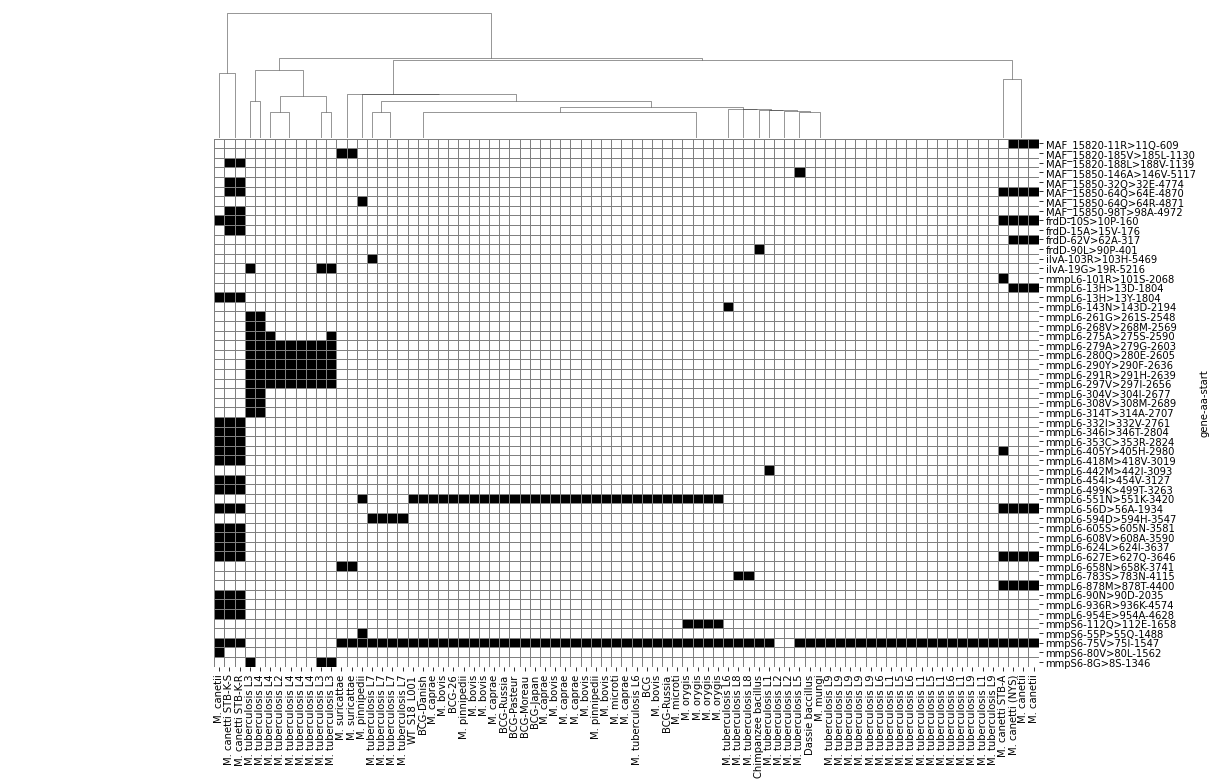

In [34]:
cm=sns.clustermap(X,row_cluster=False,cmap='gray_r',figsize=(17,11),linecolor='gray',
                  xticklabels=True,yticklabels=True,lw=.5)
cm.cax.set_visible(False)
cm.savefig('snp_clustermap_tbd1.png',dpi=200,facecolor="w")

## phylogeny based on snps

In [33]:
trees.run_RAXML('snpgenie_results/core.fa',outpath='temp')

raxmlHPC-PTHREADS -f a -N 100 -T 8 -m GTRCAT -V -p 92787865 -x 56388780 -n variants -w /home/farrell/gitprojects/mtbc_analyses/tbd1/temp -s snpgenie_results/core.fa


'/home/farrell/gitprojects/mtbc_analyses/tbd1/temp/RAxML_bipartitions.variants'

In [ ]:
reload(trees)
colormap = trees.colors_from_labels(samples,'ACCESSION','LINEAGE')
labelmap = dict(zip(samples.ACCESSION,samples.LINEAGE))
tree,ts = trees.create_tree('temp/RAxML_bestTree.variants',None,labelmap,colormap)
names=['M. canetti STB-K-S','M. canetti STB-K-R']
trees.remove_nodes(tree, names)

ts.scale = 5000
#ts.mode = 'c'
ts.margin_left = 10
ts.branch_vertical_margin = 1
#ts.force_topology = True
tree.render('%%inline',tree_style=ts,w=400)

# detect deletions

We can do this visually or automate it

In [10]:
def get_coverage(bam_file, chr, start, end, ref):
    cmd = 'samtools mpileup {b} --min-MQ 10 -f {r} -r {c}:{s}-{e}'.format(c=chr,s=start,e=end,b=bam_file,r=ref)
    #print(cmd)
    temp = subprocess.check_output(cmd, shell=True)    
    df=pd.read_csv(io.BytesIO(temp), sep='\t', names=['chr','pos','base','coverage','q','c'])
    return df


## show coverage

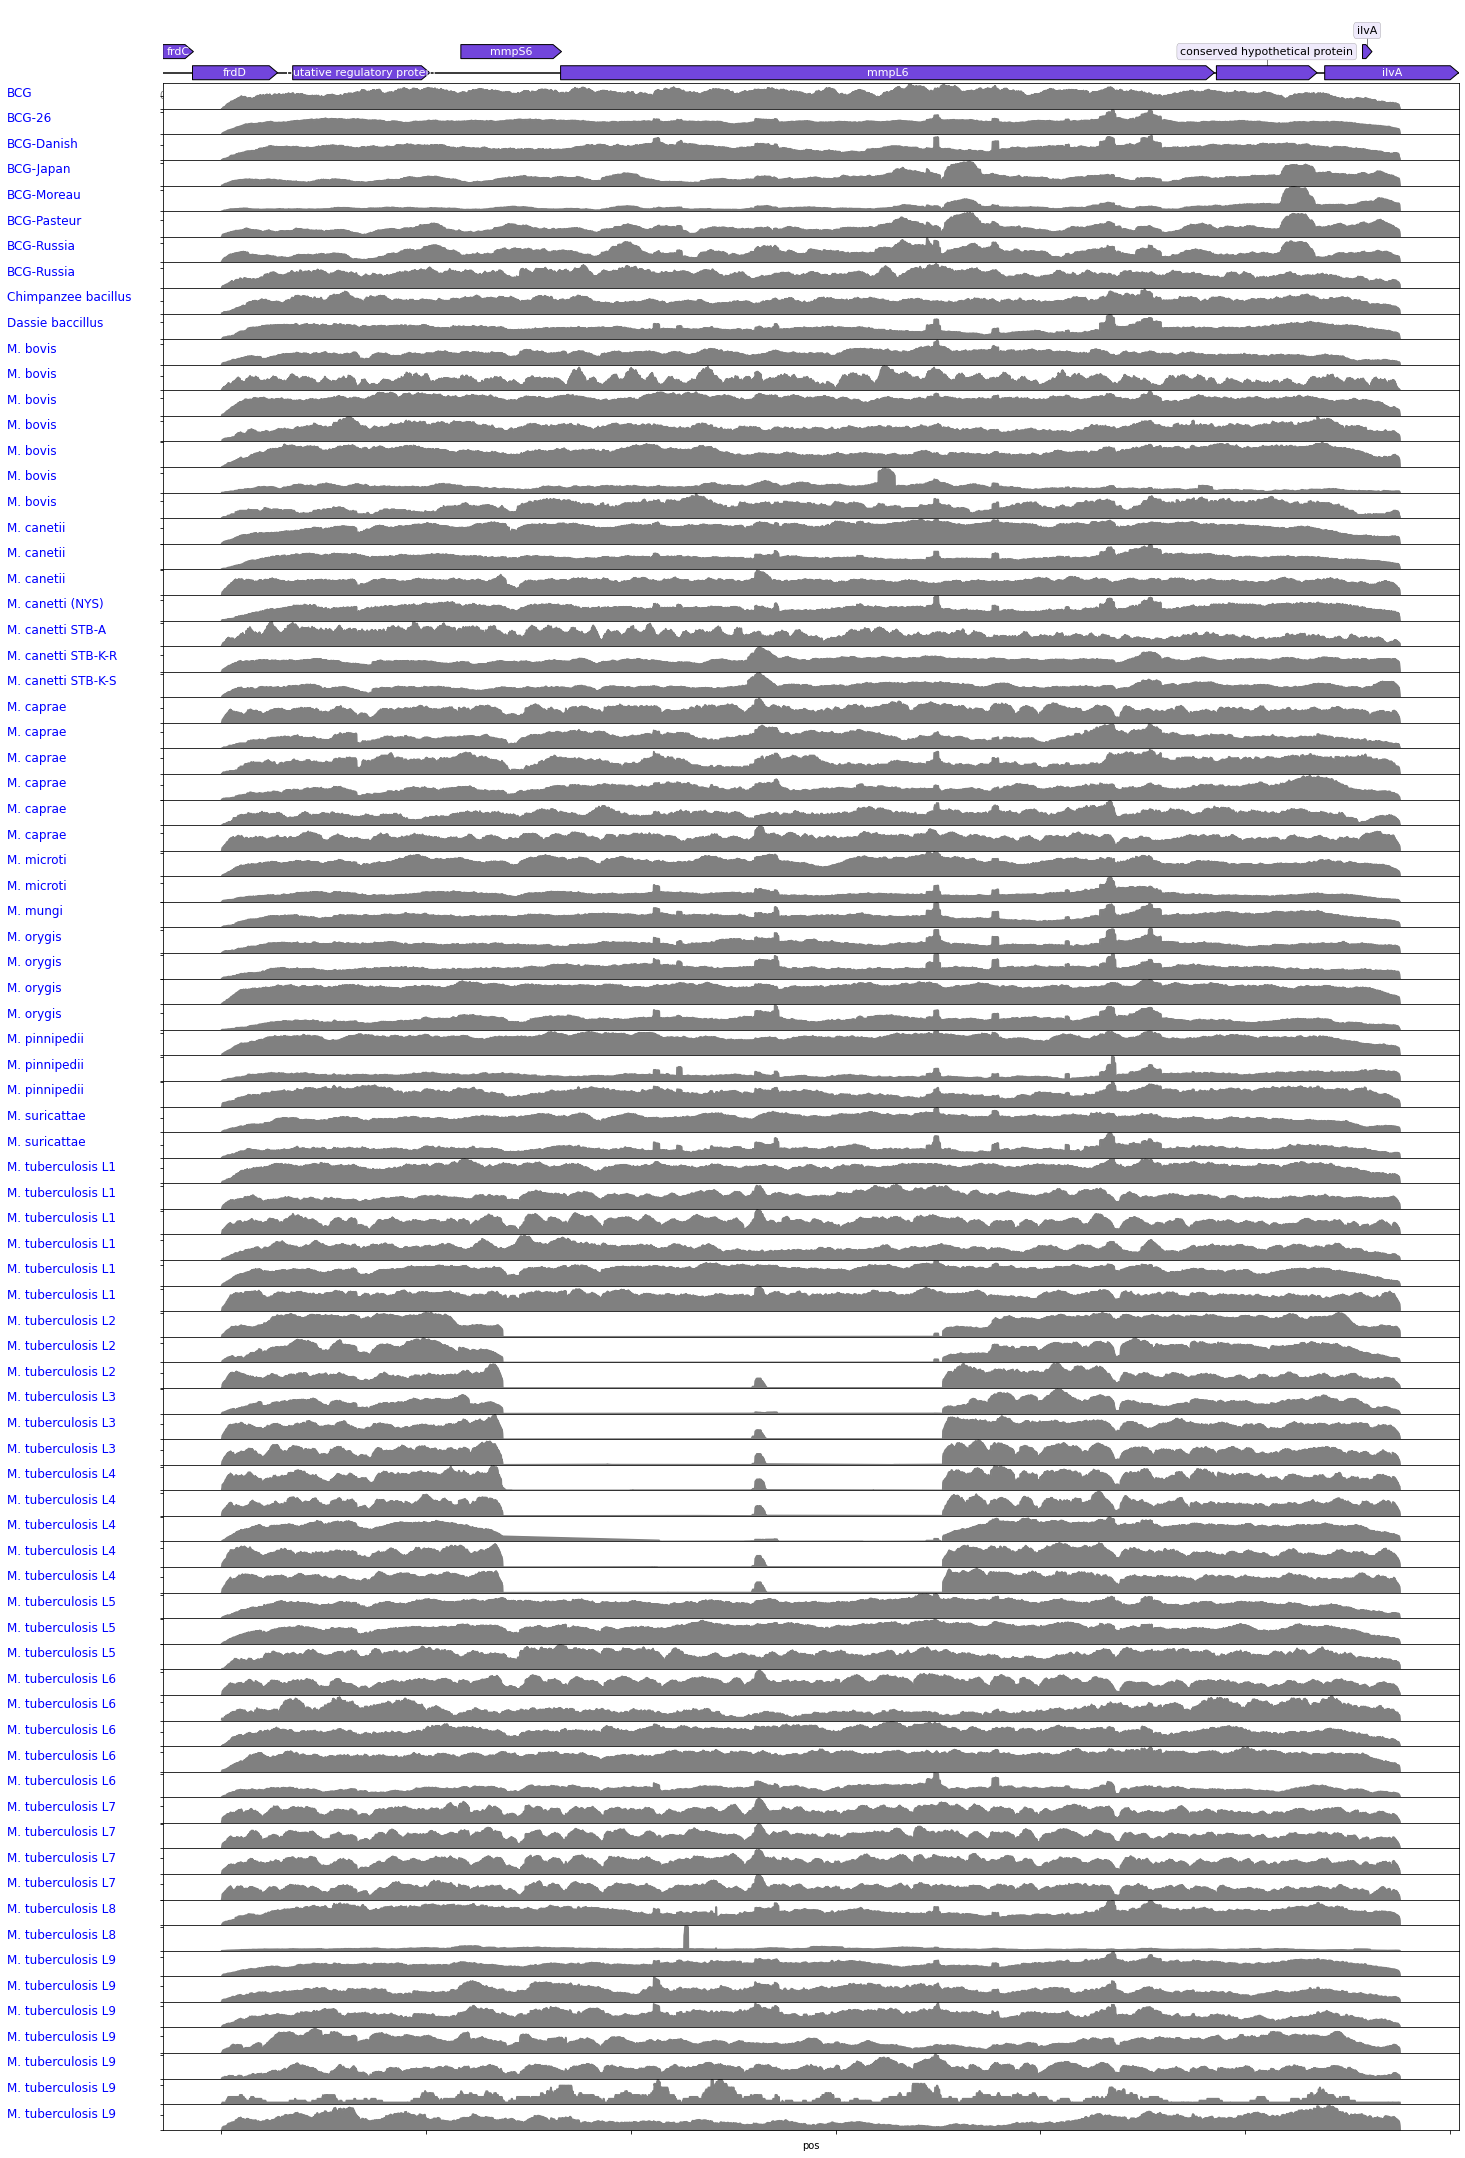

In [11]:
from dna_features_viewer import GraphicFeature, GraphicRecord
from dna_features_viewer import BiopythonTranslator

graphic_record = BiopythonTranslator().translate_record(rec)
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(30,40))
gs = GridSpec(len(samples)+5, 1, figure=fig)
ax1=fig.add_subplot(gs[:3,0])
graphic_record.plot(ax=ax1)
i=3
for n,r in list(samples.iterrows()):#[40:60]:
    ax=fig.add_subplot(gs[i,0])
    df = get_coverage(r.bam_file,'MAF_TBD1',1,len(rec.seq),'MAF_GM041182_TBD1.fa')
    #bins=range(0,max(df.coverage),int(max(df.coverage)/10))
    #df['binned']=np.searchsorted(bins, df.coverage.values)
    df.plot(x='pos',y='coverage',ax=ax,kind='area',color='gray',legend=False)
    label=r.LINEAGE
    ax.text(-.12,.5,label,color='blue',transform=ax.transAxes,fontsize=12)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    i+=1
plt.subplots_adjust(left=.3,right=.9,wspace=0, hspace=0)

## other mmpL proteins

In [12]:
ref = tools.genbank_to_dataframe('GM041182.gb')
ref = ref[ref.feat_type=='CDS']

In [13]:
mmpl = ref[ref.gene.fillna('').str.contains('mmpL')]
mmpl

,gene,locus_tag,inference,id,start,end,strand,feat_type,sequence
473,mmpL11,MAF_02030,NaN,NC_015758.1,235045,237946,-1,CDS,ATGATGCGCTTGAGCCGCAACCTGCGCAGGTGCCGTTGGTTGGTCT...
481,mmpL3,MAF_02070,NaN,NC_015758.1,241137,243972,-1,CDS,GTGTTCGCCTGGTGGGGTCGAACTGTGTACCGCTACCGGTTCATCG...
932,mmpL1,MAF_04040,NaN,NC_015758.1,477091,479968,-1,CDS,GTGAGGAGCCAACGTCTAGCCGGGCACCTGTCGGCCGCCGCCCGGA...
1045,mmpL4,MAF_04520,NaN,NC_015758.1,535309,538213,-1,CDS,GTGAGTACTAAATTCGCGAACGACTCCAATACCAACGCTCGCCCCG...
1179,mmpL2,MAF_05140,NaN,NC_015758.1,593958,596865,1,CDS,ATGAGCGAAAGACACGCCGCACTGACGTCACTGCCGCCCATTCTGC...
1582,mmpL5,MAF_06850,NaN,NC_015758.1,772974,775869,-1,CDS,ATGATCGTGCAAAGGACAGCTGCGCCGACGGGCTCCGTCCCGCCCG...
2710,mmpL13a,MAF_11620,NaN,NC_015758.1,1269797,1270709,1,CDS,ATGCTGCAGAGGATCGCTCGGCTCGCCATCGCTGCGCCGCGCCGAA...
2712,mmpL13b,MAF_11630,NaN,NC_015758.1,1270730,1272143,1,CDS,GTGGCTACCGTGGCATTCGTCGCGACCGCGTCGATCGTGATCACCC...
2803,mmpL10,MAF_12020,NaN,NC_015758.1,1320251,1323260,1,CDS,GTGGTCGGCTGTTGGGTCGCGCTCGCCCTGGTACTGCCGATGGCGG...
3646,mmpL12,MAF_15490,NaN,NC_015758.1,1717802,1721243,-1,CDS,GTGGCAAGGCATGACGAGGCCAAAGCCGGGGGACTGTTCGACCGTA...


## run snipgenie against entire genome

In [ ]:
args = {'threads':22, 'outdir': '/storage/mtbc_maf_snp_results', 'labelsep':'-',  
        'input':['/storage/elena_data/'],        
        'reference': 'GM041182.fna', 'gb_file':'GM041182.gb',
        'overwrite':False
        }
W = app.WorkFlow(**args)
st = W.setup()
W.run()

## find snps in arbitary regions

In [ ]:
X=pd.read_csv('/storage/mtbc_maf_snp_results/csq.matrix')
X = X.set_index(['gene','aa','start']).sort_index()
X=X.drop(columns=['ERR1109376','ERR1109377'])
X=X[X.sum(1)>0]
labelmap = dict(zip(samples.ACCESSION,samples.LINEAGE))
X=X.rename(columns=labelmap)
X=X.loc[mmpl.gene]


In [ ]:
cm=sns.clustermap(X,row_cluster=True,cmap='gray_r',figsize=(14,15),
                  xticklabels=True,yticklabels=[])
cm.cax.set_visible(False)

In [84]:
c = app.read_csq_file('/storage/mtbc_maf_snp_results/csq.tsv')
#include only snps or also indels?
c=c[c.snp_type!='synonymous']

In [ ]:
m=c[c.gene.isin(mmpl.gene)]
m=m.merge(samples,on='sample',how='left')
